## Import Toolkit

In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
import json

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

2024-03-22 05:24:45.932529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 05:24:45.932593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 05:24:45.932616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 05:24:45.939761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_data_path = 'brain-tumor-mri-dataset/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
test_data_path = 'brain-tumor-mri-dataset/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

## Split Data into Valid and Test

In [4]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

## Image Data Generator

In [5]:
img_size = (224 ,224) # Possible Values are 300x300, 512x512, or 640x640
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## sample from train data

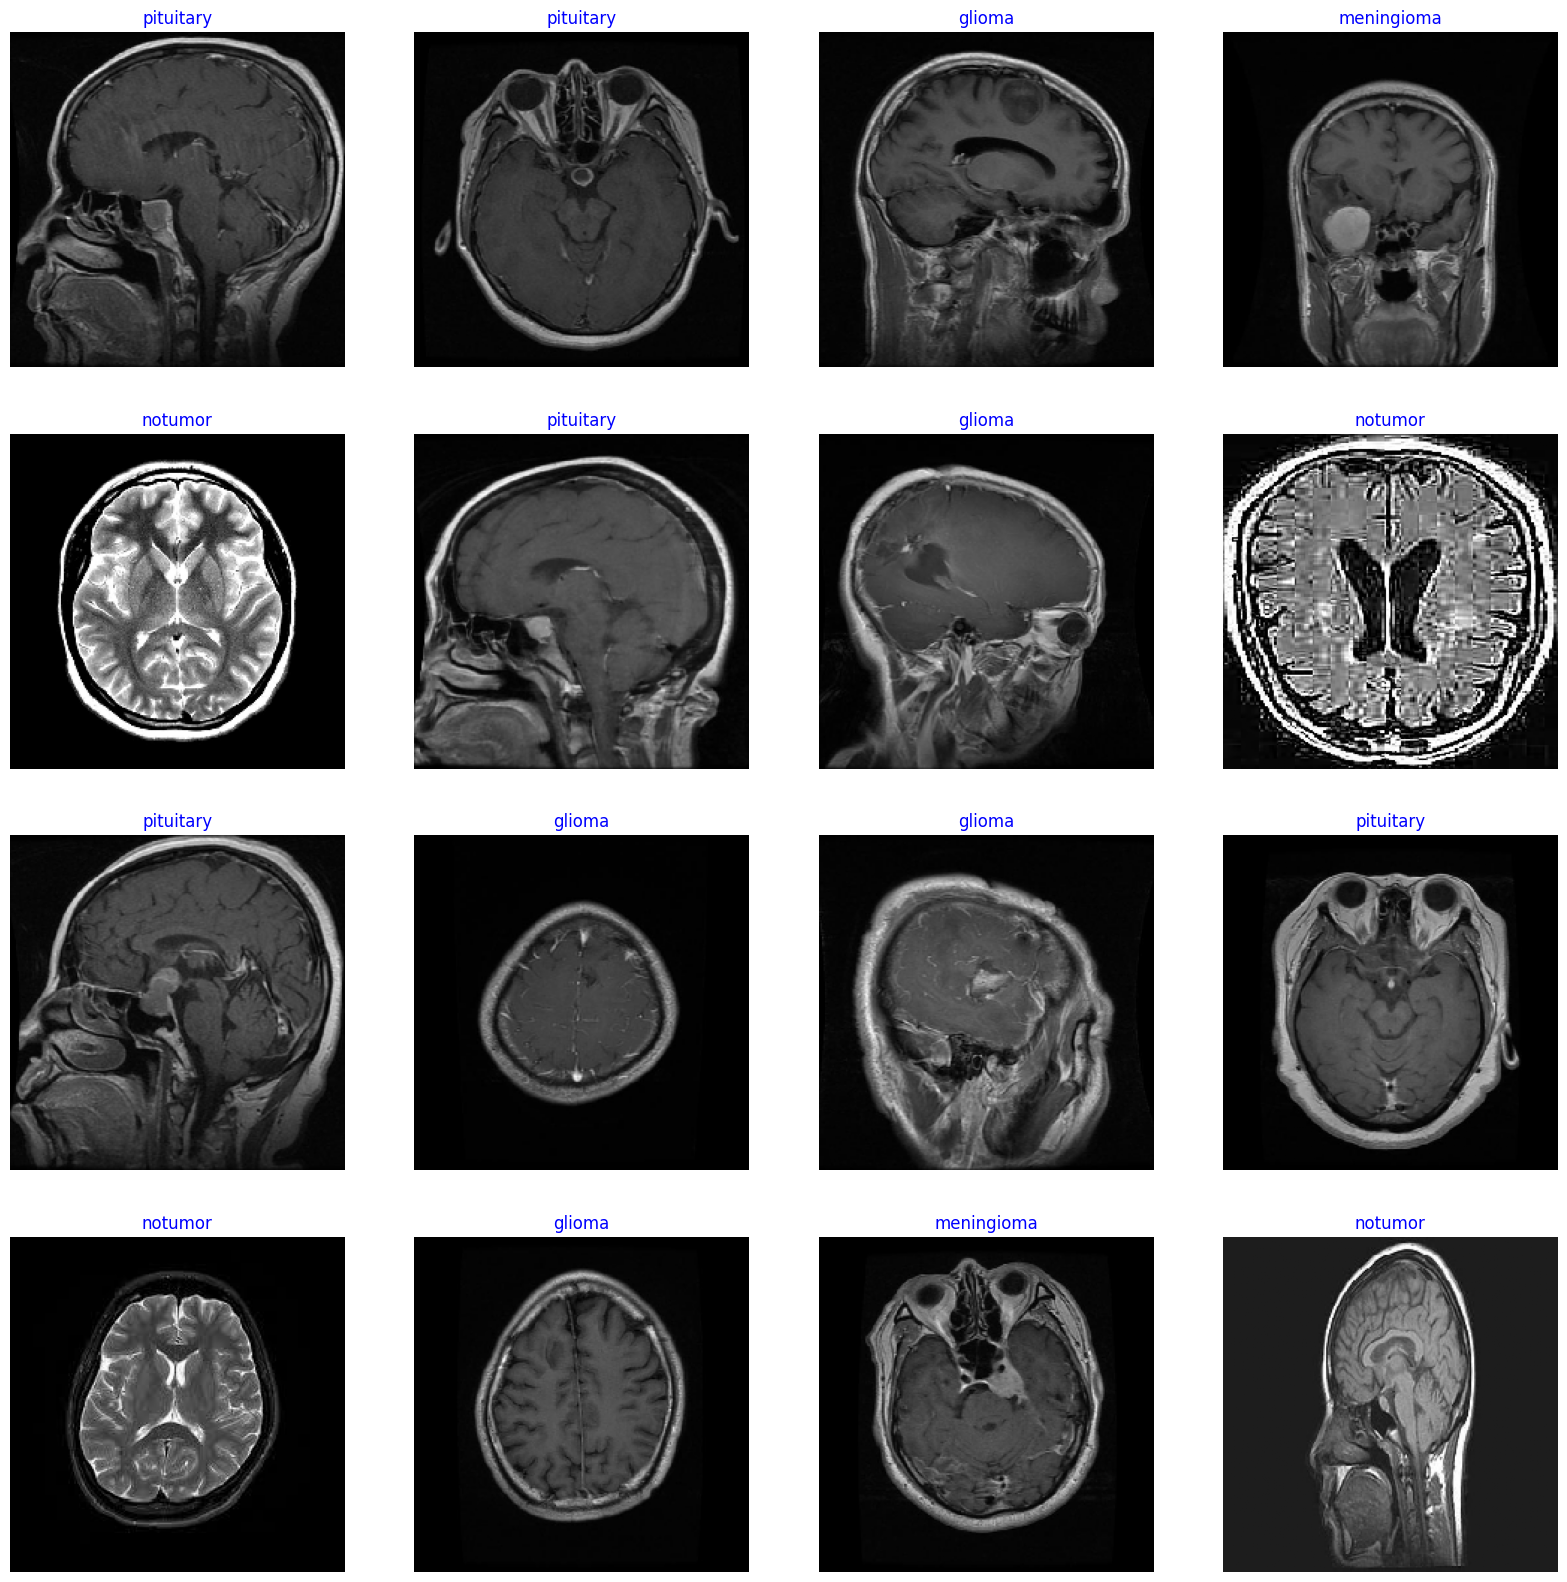

In [6]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## Model Structure

In [7]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

2024-03-22 05:24:49.712939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:45:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 1109

## Iterate

In [8]:
Epochs = 20

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,validation_steps = None , shuffle = False)

Epoch 1/20


2024-03-22 05:25:11.513358: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-22 05:25:14.298316: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-22 05:25:14.931167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-03-22 05:25:14.997391: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-22 05:25:16.701394: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd230050c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 05:25:16.701447: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Co

357/357 [==============================] - 100s 131ms/step - loss: 5.8803 - accuracy: 0.8587 - val_loss: 3.9701 - val_accuracy: 0.9053
Epoch 2/20
357/357 [==============================] - 45s 125ms/step - loss: 2.8208 - accuracy: 0.9513 - val_loss: 1.9188 - val_accuracy: 0.9786
Epoch 3/20
357/357 [==============================] - 45s 125ms/step - loss: 1.4457 - accuracy: 0.9708 - val_loss: 0.9973 - val_accuracy: 0.9817
Epoch 4/20
357/357 [==============================] - 44s 124ms/step - loss: 0.7512 - accuracy: 0.9842 - val_loss: 0.5241 - val_accuracy: 0.9878
Epoch 5/20
357/357 [==============================] - 44s 124ms/step - loss: 0.4385 - accuracy: 0.9848 - val_loss: 0.3309 - val_accuracy: 0.9847
Epoch 6/20
357/357 [==============================] - 44s 124ms/step - loss: 0.2888 - accuracy: 0.9891 - val_loss: 0.2364 - val_accuracy: 0.9893
Epoch 7/20
357/357 [==============================] - 44s 123ms/step - loss: 0.2134 - accuracy: 0.9933 - val_loss: 0.1864 - val_accuracy: 0.

#### Save the Model

In [9]:
model.save('effb3.keras')

## Model Performance

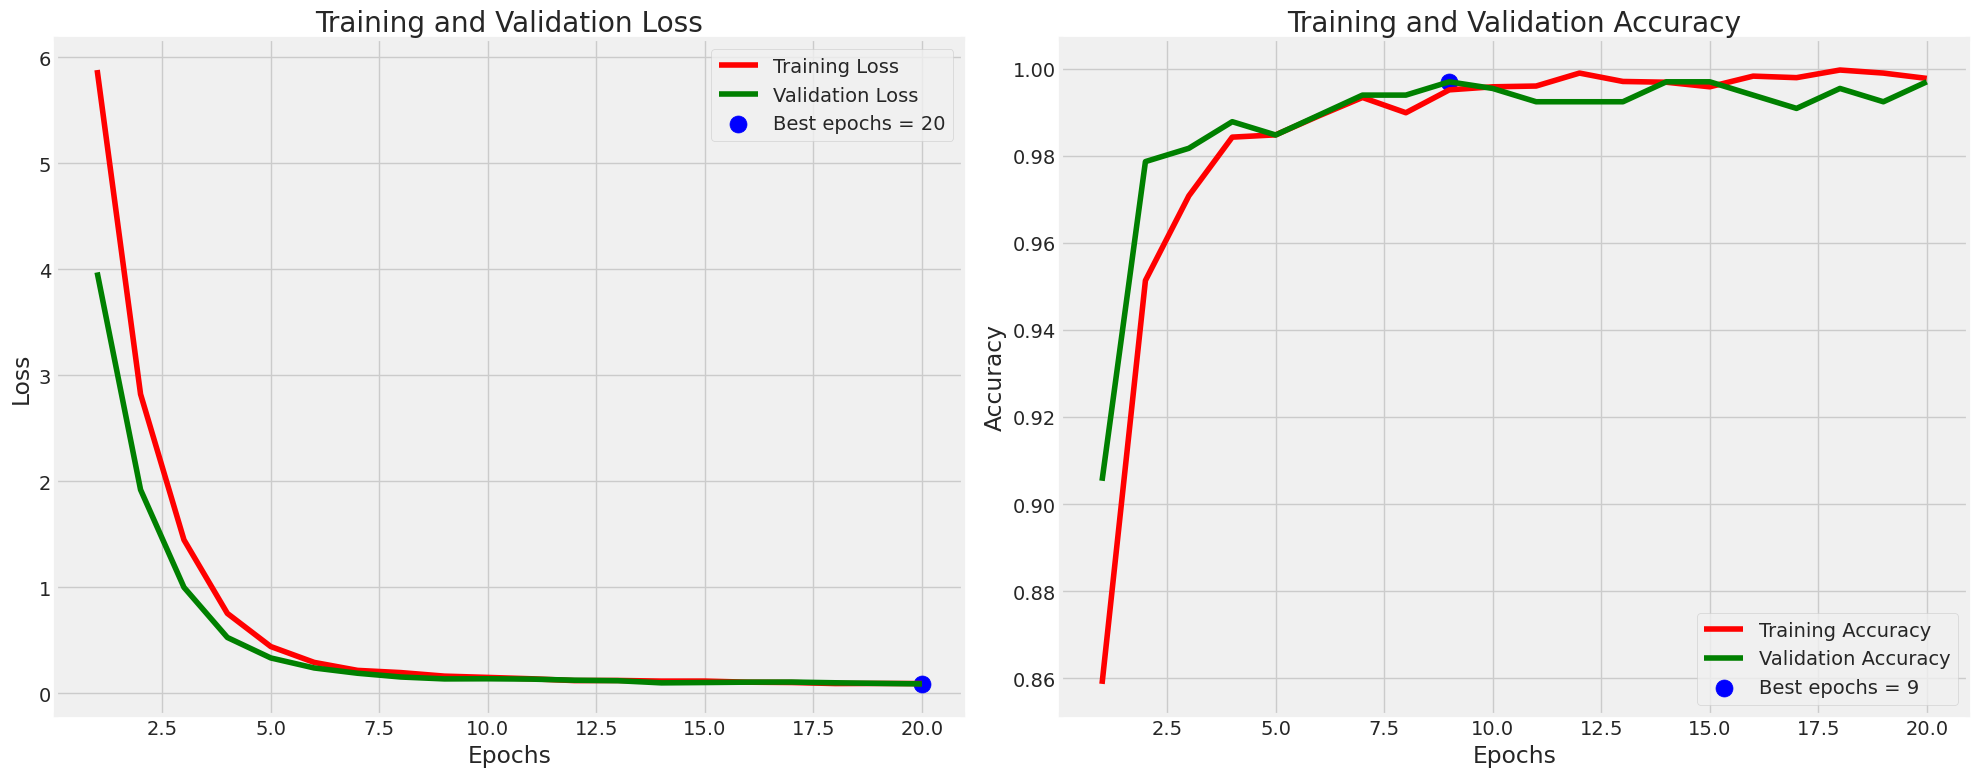

In [10]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('training_validation_plots.png')
plt.show()

## Model Evaluation

In [11]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 32ms/step - loss: 0.1120 - accuracy: 0.9844
Train Loss:  0.07462120801210403
Train Accuracy:  1.0
--------------------
Validation Loss:  0.10151620954275131
Validation Accuracy:  0.9921875
--------------------
Test Loss:  0.1119997501373291
Test Accuracy:  0.984375


In [12]:
with open('model_scores.txt', 'w') as file:
    file.write("Train Loss: {}\n".format(train_score[0]))
    file.write("Train Accuracy: {}\n".format(train_score[1]))
    file.write('-' * 20 + '\n')
    file.write("Validation Loss: {}\n".format(valid_score[0]))
    file.write("Validation Accuracy: {}\n".format(valid_score[1]))
    file.write('-' * 20 + '\n')
    file.write("Test Loss: {}\n".format(test_score[0]))
    file.write("Test Accuracy: {}\n".format(test_score[1]))

print("Scores saved successfully.")

Scores saved successfully.


## Model Prediction

## Confusion Matrix and Classification Report

In [13]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

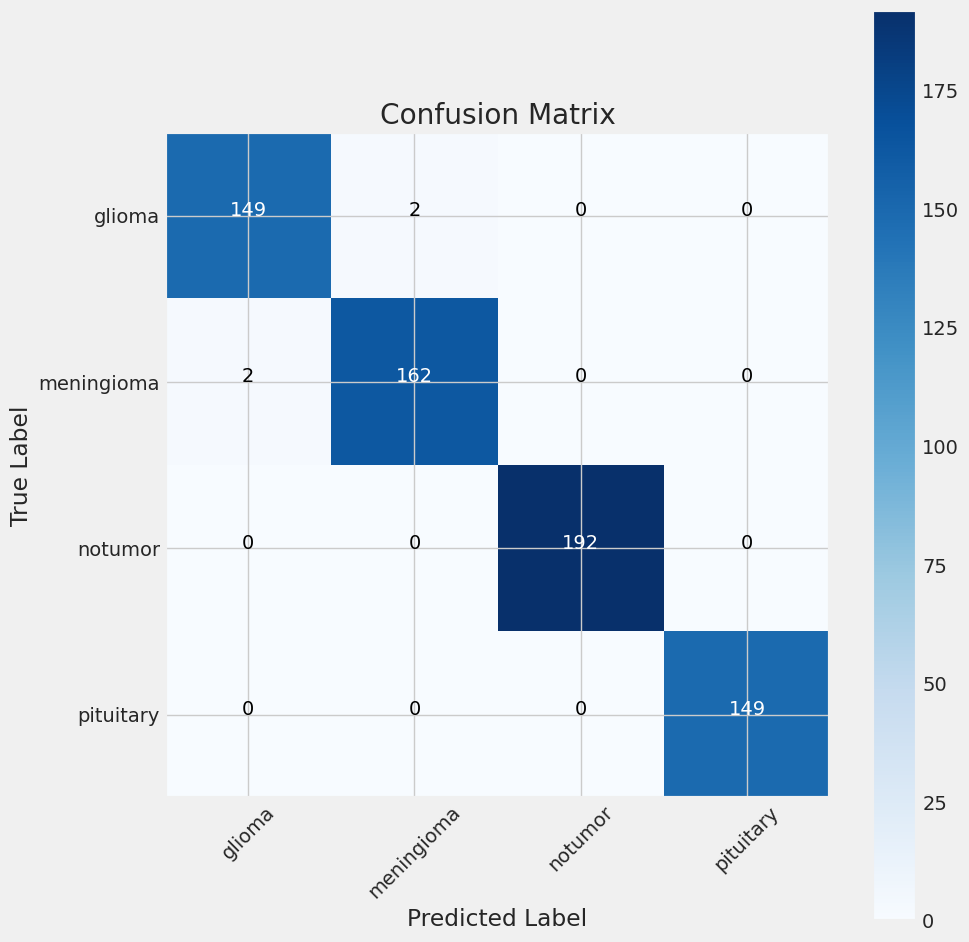

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('Confusion_Matrix.png')
plt.show()

In [15]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

# Save the classification report to json 
report = classification_report(test_gen.classes, y_pred , target_names= classes , output_dict= True)
report_df = pd.DataFrame(report).transpose()
report_df.to_json('classification_report.json')

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       151
  meningioma       0.99      0.99      0.99       164
     notumor       1.00      1.00      1.00       192
   pituitary       1.00      1.00      1.00       149

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [16]:
precision = report_df['precision']
recall = report_df['recall']
f1_score = report_df['f1-score']
classes = report_df.index

# Calculate TPR and FPR for each class
tpr = recall
fpr = 1 - precision

# Save TPR and FPR to a DataFrame
tpr_fpr_df = pd.DataFrame({'TPR': tpr, 'FPR': fpr}, index=classes)


tpr_fpr_json = tpr_fpr_df.to_json(orient='index')
print(tpr_fpr_df)
# Write JSON to file
with open('tpr_fpr.json', 'w') as f:
    json.dump(tpr_fpr_json, f)

print("TPR and FPR saved as JSON.")

                   TPR       FPR
glioma        0.986755  0.013245
meningioma    0.987805  0.012195
notumor       1.000000  0.000000
pituitary     1.000000  0.000000
accuracy      0.993902  0.006098
macro avg     0.993640  0.006360
weighted avg  0.993902  0.006098
TPR and FPR saved as JSON.


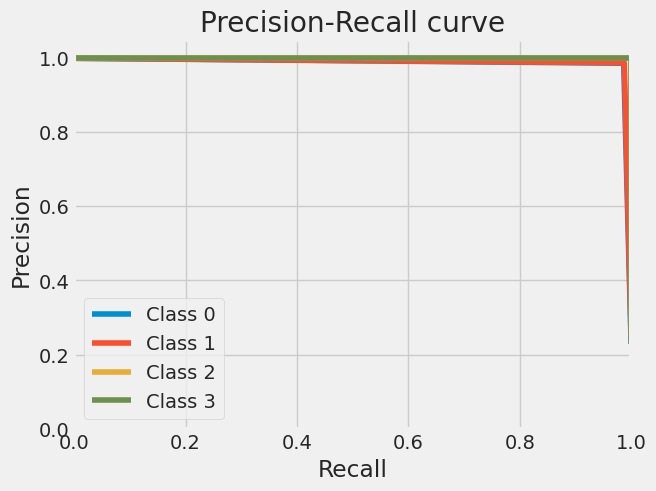

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming you have predictions (preds) and true labels (y_true) for your test set
num_classes = 4
# Get true labels from test_gen
y_true = np.array(test_gen.classes)

# Binarize the predicted probabilities or scores
y_pred_binarized = label_binarize(y_pred, classes=range(num_classes))

# Calculate precision and recall for each class separately
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve((y_true == i).astype(int), y_pred_binarized[:, i])
    plt.plot(recall[i], precision[i], label='Class {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('precision_recall_curve_multiclass.png')
plt.show()


In [45]:
def predict(img_path, model):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(train_gen.class_indices.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(label, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    print(label)
    print(probs)
    plt.show()

In [19]:
from keras.models import load_model
model1 = load_model('effb3.keras')

In [22]:
import sys

# Save model summary to a text file
with open('model_summary.txt', 'w') as f:
    # Redirect stdout to the text file
    sys.stdout = f
    # Print the model summary
    model.summary()
    # Reset stdout to the console
    sys.stdout = sys.__stdout__

print("Model summary saved as 'model_summary.txt'")


Model summary saved as 'model_summary.txt'
1/1 [==============================] - 0s 40ms/step
[[3.1378464e-04 4.8233231e-04 9.9887270e-01 3.3109280e-04]]
1/1 [==============================] - 0s 38ms/step
[[3.1378464e-04 4.8233231e-04 9.9887270e-01 3.3109280e-04]]
1/1 [==============================] - 0s 38ms/step
[0.00031378464, 0.0004823323, 0.9988727, 0.0003310928]
1/1 [==============================] - 0s 34ms/step
['glioma', 'meningioma', 'notumor', 'pituitary']
1/1 [==============================] - 0s 38ms/step
['glioma', 'meningioma', 'notumor', 'pituitary']
1/1 [==============================] - 0s 40ms/step
['glioma', 'meningioma', 'notumor', 'pituitary']
1/1 [==============================] - 0s 40ms/step
[0.00030384926, 0.00046126056, 0.9989116, 0.0003232898]
1/1 [==============================] - 0s 40ms/step
[0.0003007568, 0.00046030144, 0.99891865, 0.00032030878]
1/1 [==============================] - 0s 40ms/step
['glioma', 'meningioma', 'notumor', 'pituitary']
[0.00

In [61]:
from keras.preprocessing import image

# Specify the path to the image you want to use
image_path = "brain-tumor-mri-dataset/Testing/meningioma/Te-me_0015.jpg"  # Change this to the actual path of your image

# Load the image
img = image.load_img(image_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Predict class probabilities for the image
prediction = model1.predict(img_array)[0]

# Get the index of the predicted class with the highest probability
predicted_class_index = np.argmax(prediction)

# Map class index to class name
# class_names = train_gen.class_indices
# class_names = dict((v, k) for k, v in class_names.items())
class_names = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
print(class_names)
predicted_class_name = class_names[predicted_class_index]

# Show the result
# plt.imshow(img)
# plt.title(f'Predicted Class: {predicted_class_name}\nConfidence: {prediction[predicted_class_index]:.2f}')
# plt.axis('off')
# plt.show()
